In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
import seaborn as sns

In [3]:
df = pd.read_csv(r'C:\Users\bugat\Prosjekter\Tekstanalyse\git_NLP\Tekstanalyse\git_NLP_data\new_df.csv')

df['All_text'] = df['All_text'].replace(['U.S.', 'U.S.A.'], ['US', 'USA'], regex=True)
df['Processed'] = df['Processed'].fillna(0)
df['Processed'] = df['Processed'].astype(str)
df['All_text'] = df['All_text'].fillna(0)
df['All_text'] = df['All_text'].astype(str)

# df.to_csv('new_df.csv', index=False)

# Making the relevant columns to lists
all_texts = (df['All_text'].to_list())
texts = df['Processed'].to_list()

# Setting the wanted text for further modelling
corpus = texts

tokenizer = Tokenizer(oov_token='<OOV>') # Hyperparameters = num_words=vocab_size, oov_token=oov_tok
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.\n\nFirst 10 is listen below:')
print(dict(list(word_index.items())[0:10]))

Found 22234 unique tokens.

First 10 is listen below:
{'<OOV>': 1, 'people': 2, 'like': 3, 'work': 4, 'right': 5, 'trump': 6, 'think': 7, 'state': 8, 'government': 9, 'party': 10}


In [4]:
my_path = r'C:\Users\bugat\Prosjekter\Tekstanalyse\git_NLP\Tekstanalyse'
log_base = my_path + '/logs/'
model_save_dir = my_path + '/models'

In [5]:
# Last inn 'X_train_LSTM' fra en CSV-fil
X_train_LSTM = pd.read_csv(my_path+'/git_NLP_data/X_train.csv')
# Konverter hele DataFrame til et NumPy array
X_train_LSTM = X_train_LSTM.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_train_LSTM = pd.read_csv(my_path +'/git_NLP_data/y_train.csv')
# Konverter hele DataFrame til et NumPy array
y_train_LSTM = y_train_LSTM.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(my_path +'/git_NLP_data/embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()

In [6]:
from tensorflow.keras.layers import Layer
import tensorflow as tf


# class SelfAttention(Module):
#     "Self attention layer for `n_channels`."
#     def __init__(self, n_channels):
#         self.query,self.key,self.value = [self._conv(n_channels, c) for c in (n_channels//8,n_channels//8,n_channels)]
#         self.gamma = nn.Parameter(tensor([0.]))

#     def _conv(self,n_in,n_out):
#         return ConvLayer(n_in, n_out, ks=1, ndim=1, norm_type=NormType.Spectral, act_cls=None, bias=False)

#     def forward(self, x):
#         #Notation from the paper.
#         size = x.size()
#         x = x.view(*size[:2],-1)
#         f,g,h = self.query(x),self.key(x),self.value(x)
#         beta = F.softmax(torch.bmm(f.transpose(1,2), g), dim=1)
#         o = self.gamma * torch.bmm(h, beta) + x
#         return o.view(*size).contiguous()

class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)
        
        # score shape == (batch_size, max_len, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        
        # attention_weights shape == (batch_size, max_len, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense
from tensorflow.keras.layers import GlobalMaxPooling1D, Concatenate, Dropout, Embedding

def build_model(input_shape, embeddings_GloVe, num_classes, number_of_parallel_blocks):
    sequence_input = Input(shape=input_shape, dtype='int32')
    
    embedded_sequences = Embedding(input_dim=embeddings_GloVe.shape[0],
                                   output_dim=embeddings_GloVe.shape[1],
                                   weights=[embeddings_GloVe],
                                   trainable=False)(sequence_input)
    
    conv_blocks = []
    pooled_attention_outputs = []
    for _ in range(number_of_parallel_blocks):
        conv = Conv1D(filters=32, kernel_size=1, activation='relu')(embedded_sequences)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)
        
        lstm = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
        attention_layer = BahdanauAttention(20)
        attention_output, attention_weights = attention_layer(lstm, lstm)
        # Pool the attention output to reduce dimensionality
        pooled_attention = GlobalMaxPooling1D()(attention_output)
        pooled_attention_outputs.append(pooled_attention)
    
    # Concatenating pooled attention outputs with conv outputs
    concatenated = Concatenate()(conv_blocks + pooled_attention_outputs)
    concatenated = Dropout(0.2)(concatenated)
    output = Dense(num_classes, activation='sigmoid')(concatenated)
    
    return Model(sequence_input, output), attention_weights

# Define the number of classes, number of parallel blocks, and build the model
num_classes = 2  # Or however many classes you are classifying between
number_of_parallel_blocks = 1  # Define the number of parallel blocks you want
input_length = 20
model, attention_weights = build_model((input_length,), embeddings_GloVe, num_classes, number_of_parallel_blocks)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Using the existing layers and architecture to define a new model that also outputs attention weights
model_with_attention = Model(inputs=model.input, 
                             outputs=[model.output, attention_weights])

# Assuming `input_data` is your input prepared as per the model's expected input shape
predictions, pooled_attention = model_with_attention.predict(X_train_LSTM)



402/402 [==============================] - 4s 7ms/step


In [ ]:
n_splits=5

KF = KFold(n_splits=n_splits, shuffle=True, random_state=42) # Example: 5-fold cross-validation

# Prepare arrays to store results for each fold
fold_no = 1
loss_per_fold = []
acc_per_fold = []

for train, test in KF.split(X_train_LSTM, y_train_LSTM):
    # Create a fresh model for each fold

    # Fit the model
    model.fit(X_train_LSTM[train], y_train_LSTM[train],
                        epochs=n_splits,  # Adjust based on your needs
                        batch_size=64,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)],
                        validation_data=(X_train_LSTM[test], y_train_LSTM[test]),
                        verbose=1)  # You can set verbose to 0 to reduce logs

    # Evaluate the model
    scores = model.evaluate(X_train_LSTM[test], y_train_LSTM[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# Print average scores
print(f'Average scores for all folds:\n> Loss: {np.mean(loss_per_fold)}; Accuracy: {np.mean(acc_per_fold)}%')

Epoch 1/5


161/161 [==============================] - 14s 57ms/step - loss: 0.6475 - accuracy: 0.6469 - val_loss: 0.6049 - val_accuracy: 0.6814
Epoch 2/5
161/161 [==============================] - 8s 50ms/step - loss: 0.6025 - accuracy: 0.6765 - val_loss: 0.5367 - val_accuracy: 0.7192
Epoch 3/5
161/161 [==============================] - 8s 50ms/step - loss: 0.5684 - accuracy: 0.7027 - val_loss: 0.5163 - val_accuracy: 0.7375
Epoch 4/5
161/161 [==============================] - 8s 51ms/step - loss: 0.5395 - accuracy: 0.7293 - val_loss: 0.5045 - val_accuracy: 0.7565
Epoch 5/5
161/161 [==============================] - 8s 51ms/step - loss: 0.5153 - accuracy: 0.7479 - val_loss: 0.5007 - val_accuracy: 0.7561
Score for fold 1: loss of 0.500296413898468; accuracy of 75.65149664878845%
Epoch 1/5
161/161 [==============================] - 8s 50ms/step - loss: 0.4966 - accuracy: 0.7596 - val_loss: 0.4663 - val_accuracy: 0.7837
Epoch 2/5
161/161 [==============================] - 8s 51ms/step - l

In [ ]:
# Using the existing layers and architecture to define a new model that also outputs attention weights
model_with_attention = Model(inputs=model.input, 
                             outputs=[model.output, attention_weights])

# Assuming `input_data` is your input prepared as per the model's expected input shape
predictions, actual_attention_weights = model_with_attention.predict(X_train_LSTM)

402/402 [==============================] - 6s 11ms/step


In [ ]:
# Assuming attention_weights is your input array
attention_weights_np = np.array(actual_attention_weights[0], dtype=np.float32)

In [ ]:
attention_weights_np

array([[[5.71919158e-02],
        [3.54272500e-02],
        [1.43939909e-02],
        [3.90018113e-02],
        [1.01616159e-02],
        [4.84956108e-05],
        [2.19006361e-05],
        [6.65557764e-07],
        [4.00239187e-05],
        [3.37388506e-03],
        [8.72437209e-02],
        [4.32245880e-02],
        [7.60010555e-02],
        [1.46867055e-02],
        [1.23177618e-02],
        [3.57937366e-02],
        [6.92529082e-02],
        [7.39824623e-02],
        [6.62980452e-02],
        [5.74865229e-02]],

       [[3.10160257e-02],
        [1.84595324e-02],
        [1.13420524e-02],
        [2.24813502e-02],
        [1.05063813e-02],
        [1.00587960e-03],
        [1.87694363e-03],
        [9.94783454e-03],
        [4.29560207e-02],
        [2.75328793e-02],
        [1.92981996e-02],
        [2.32129768e-02],
        [1.73002910e-02],
        [2.72898115e-02],
        [2.93585714e-02],
        [3.21142748e-02],
        [3.03401742e-02],
        [3.01509239e-02],
        [3

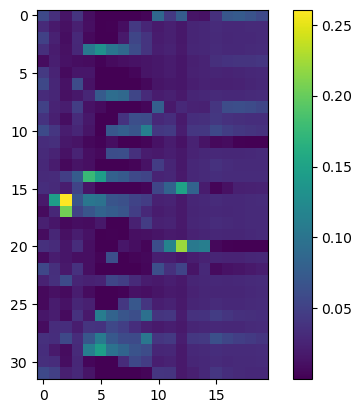

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_attention_heatmap(attention_weights):
    # Assuming attention_weights is a 2D NumPy array
    fig, ax = plt.subplots()
    heatmap = ax.imshow(attention_weights, cmap='viridis')
    plt.colorbar(heatmap)
    plt.close(fig)  # Prevents the figure from being displayed here
    return fig

# Example usage within a training loop or after predictions
fig = plot_attention_heatmap(attention_weights_np)
fig